# Image Scoring
___


In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from scipy.io import loadmat
from matplotlib.patches import Patch
from collections import Counter
from PIL import Image
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys

#--------------------------------------------------------------------------
#Change this path to your main folder if it differs from this
sys.path.append("/content/drive/MyDrive/cv_segmentation_workshop")
#--------------------------------------------------------------------------

In [4]:
import perceptual_scoring
from perceptual_scoring import (
    compute_image_metrics,
    lighting_score,
    visual_comfort_score,
    affective_tone_score,
    aesthetic_enrichment_score,
    compute_total_score,
    label_names,
    visualize_top_images
)

___
# Define your paths for your image folder, masks folder, and labels
___

In [5]:
#-----------------------------------------------------------------
base_path = "/content/drive/MyDrive/cv_segmentation_workshop"
images_path = os.path.join(base_path, "cropped_images_2")
masks_path = os.path.join(base_path, "masks_2")
csv_path = os.path.join(base_path, "segmentation_labels.csv")
color_mat_path = "/content/drive/MyDrive/cv_segmentation_workshop/color150.mat",
#-----------------------------------------------------------------

color_mat_path = color_mat_path[0]
print("Images folder:", os.path.exists(images_path))
print("Masks folder:", os.path.exists(masks_path))
print("Labels CSV:", os.path.exists(csv_path))

df_labels = pd.read_csv(csv_path)

Images folder: True
Masks folder: True
Labels CSV: True


In [6]:

"""
the previous notebooks named your images like 0001.jpg, 0002.jpg...
we need to ensure the df_labels has the same naming format to match the images in your folder
"""
df_labels["image"] = df_labels["image"].astype(str).str.zfill(4)
print(df_labels["image"].head())

0    0000
1    0001
2    0002
3    0003
4    0004
Name: image, dtype: object


In [7]:

metrics_data = []

for _, row in df_labels.iterrows():
    img_name = f"{row['image']}.jpg"
    img_path = os.path.join(images_path, img_name)

    metrics = compute_image_metrics(img_path)
    if metrics:
        metrics["image"] = row["image"]
        metrics_data.append(metrics)

df_metrics = pd.DataFrame(metrics_data)
df_metrics.head()

,B_mean,B_std,T_color,Var_color,L_var,image
0,0.5647,0.1471,-0.0596,6.9616,0.0716,0000
1,0.5736,0.1429,-0.0790,5.5067,0.0732,0001
2,0.5734,0.1291,-0.0767,6.0067,0.0910,0002
3,0.5806,0.1310,-0.0606,8.0809,0.0524,0003
4,0.5760,0.1428,-0.0487,9.2625,0.0754,0004


In [8]:

df_full = pd.merge(df_labels, df_metrics, on="image", how="inner")
df_full.head()

,image,wall,floor,ceiling,windowpane,person,chair,railing,base,column,...,stairway,bannister,monitor,swivel chair,crt screen,B_mean,B_std,T_color,Var_color,L_var
0,0000,29.8,38.9,12.8,0.2,2.5,0.7,2.9,0.6,9.3,...,0.0,0.0,0.0,0.0,0.0,0.5647,0.1471,-0.0596,6.9616,0.0716
1,0001,29.8,34.8,15.3,0.4,1.0,1.1,3.9,1.0,10.1,...,0.0,0.0,0.0,0.0,0.0,0.5736,0.1429,-0.0790,5.5067,0.0732
2,0002,37.9,31.8,18.6,0.6,0.8,0.4,2.8,2.0,1.5,...,0.0,0.0,0.0,0.0,0.0,0.5734,0.1291,-0.0767,6.0067,0.0910
3,0003,27.4,30.9,19.5,1.3,0.7,0.1,3.5,2.8,9.1,...,0.0,0.0,0.0,0.0,0.0,0.5806,0.1310,-0.0606,8.0809,0.0524
4,0004,26.7,30.5,26.6,3.1,0.4,0.0,0.9,0.9,1.9,...,0.0,0.0,0.0,0.0,0.0,0.5760,0.1428,-0.0487,9.2625,0.0754


___
# Computing the scores
___

In [9]:

scores = [
    lighting_score(df_full["image"], df_full),
    visual_comfort_score(df_full["image"], df_full),
    affective_tone_score(df_full["image"], df_full),
    aesthetic_enrichment_score(df_full["image"], df_full)
]

df_scores = scores[0]
for s in scores[1:]:
    df_scores = pd.merge(df_scores, s, on=["image"], how="outer")

In [10]:

df_scores = compute_total_score(df_scores)
df_scores

,image,lighting_score,visual_comfort_score,affective_tone_score,aesthetic_enrichment_score,total_score,rating
0,0000,60.63,77.13,17.58,10.00,63.1730,This place is alright...
1,0001,62.68,78.04,22.34,10.00,64.4160,This place is alright...
2,0002,62.90,72.70,22.24,10.00,62.3260,This place is alright...
3,0003,64.60,78.90,24.88,53.34,77.7590,This is a good space!
4,0004,64.00,65.85,21.08,10.00,59.6750,This place is alright...
5,0005,53.41,76.65,0.00,10.00,59.7740,This place is alright...
6,0006,46.94,78.10,0.00,10.00,59.0480,This place is alright...
7,0007,48.09,55.63,0.00,10.02,46.2978,This place needs some serious improvement
8,0008,52.46,68.61,0.00,10.00,56.2980,This place is alright...
9,0009,65.58,72.94,21.14,10.00,62.8540,This place is alright...


___
# Scoring Criteria  

***NOTE:*** *The scoring is not a perfect image scoring method, this is a rough method developed specifically for ***SCI 6506***. The score is mostly biased by the percentage and entropy of your labels, thus a bad score does NOT mean that your image is bad, and the score may reflect inaccurate inference of perceptual qualities of your images.*  

**Interpretation**

| Range | Rating |
|:--|:--|
| $S_{total}\ge80$ |Excellent Space! |
| $65\le S_{total}<80$ |Good Space |
| $50\le S_{total}<65$ |Fair Space |
| $S_{total}<50$ |Needs SERIOUS Improvement |
___


# Let's Visualize the top scoring images for each criteria!

***Do not edit anything below***
___

## Lighting Score

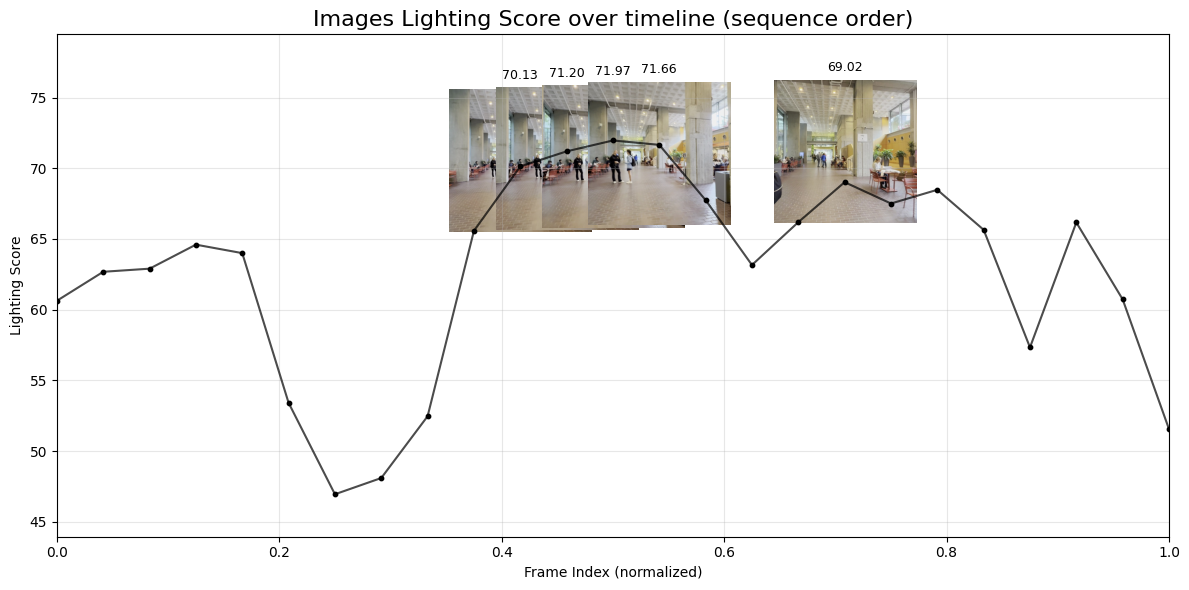

In [11]:
visualize_top_images(
    df_scores,
    images_path=images_path,
    masks_path=masks_path,
    color_mat_path=color_mat_path,
    label_names=label_names,
    score_types="lighting_score",
    #--------------------------------------------------------
    top_k=5
    #--------------------------------------------------------
)


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


___
## Visual Comfort Score

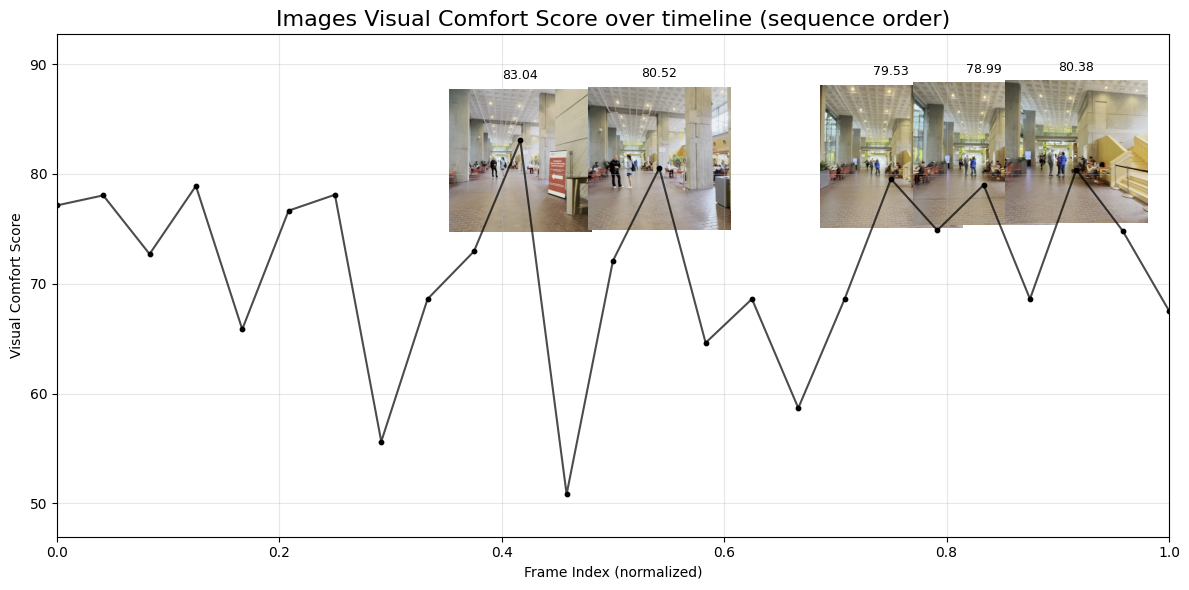

In [13]:
visualize_top_images(
    df_scores,
    images_path=images_path,
    masks_path=masks_path,
    color_mat_path=color_mat_path,
    label_names=label_names,
    score_types="visual_comfort_score",
    #--------------------------------------------------------
    top_k=5
    #--------------------------------------------------------
)

___
## Affective Tone Score

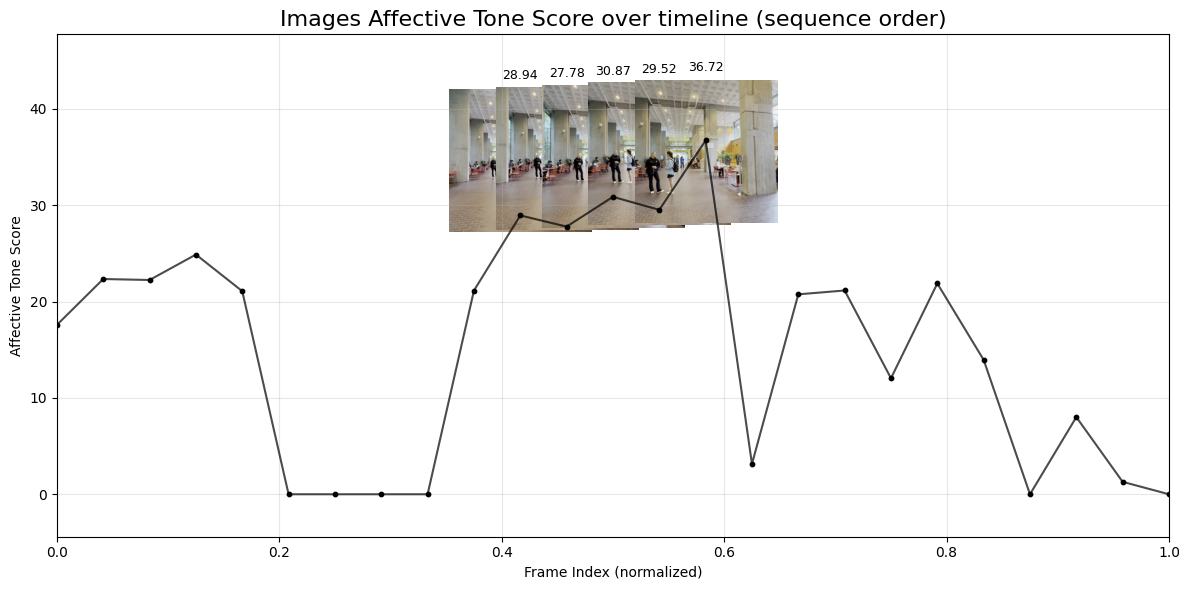

In [14]:
visualize_top_images(
    df_scores,
    images_path=images_path,
    masks_path=masks_path,
    color_mat_path=color_mat_path,
    label_names=label_names,
    score_types="affective_tone_score",
    #--------------------------------------------------------
    top_k=5
    #--------------------------------------------------------
)

___
## Aesthetic Enrichment Score

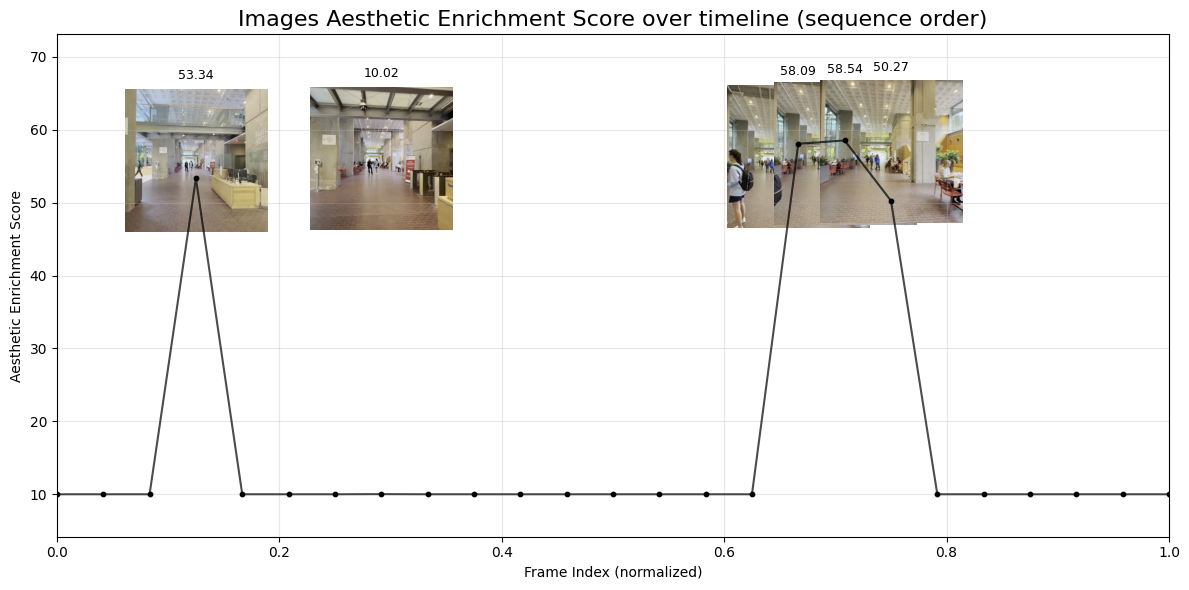

In [15]:
visualize_top_images(
    df_scores,
    images_path=images_path,
    masks_path=masks_path,
    color_mat_path=color_mat_path,
    label_names=label_names,
    score_types="aesthetic_enrichment_score",
    #--------------------------------------------------------
    top_k=5
    #--------------------------------------------------------
)

___
## Total Score

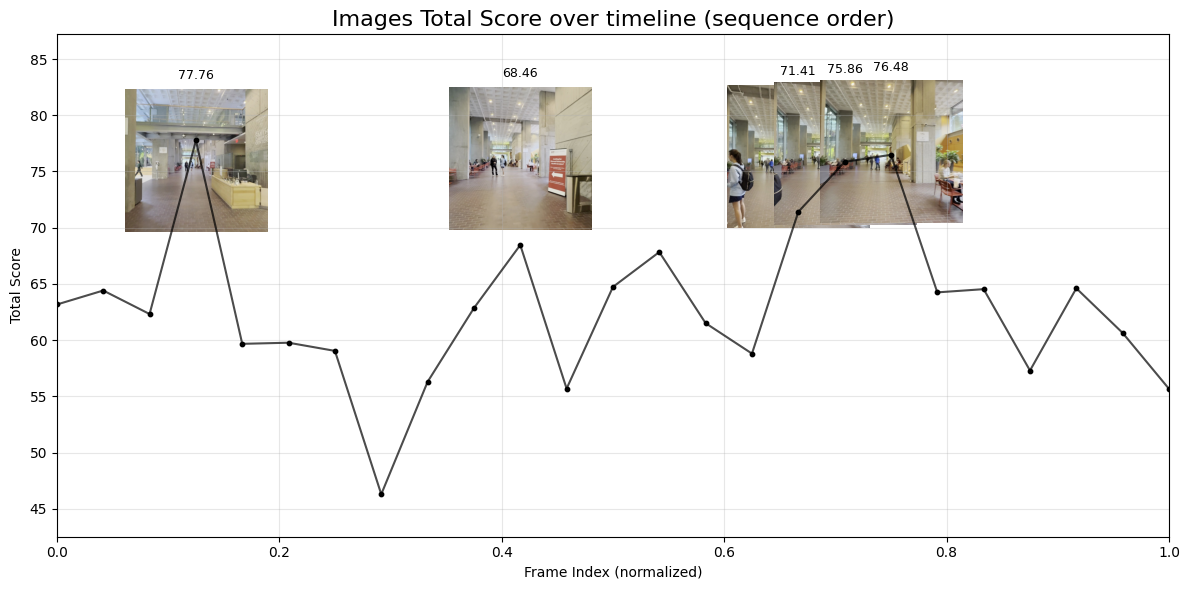

In [16]:
visualize_top_images(
    df_scores,
    images_path=images_path,
    masks_path=masks_path,
    color_mat_path=color_mat_path,
    label_names=label_names,
    score_types="total_score",
    #--------------------------------------------------------
    top_k=5
    #--------------------------------------------------------
)